<a href="https://colab.research.google.com/github/jouvetg/igm/blob/main/notebooks/IGM_start.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### <h1 align="center" id="title">IGM start tutorial </h1>

This tutorial aims to guide you modelling the great Aletsch Glacier, Switzerland, in a very simple set-up with the Instructed Glacier Model (IGM).

First of all, what is a glacier model ?


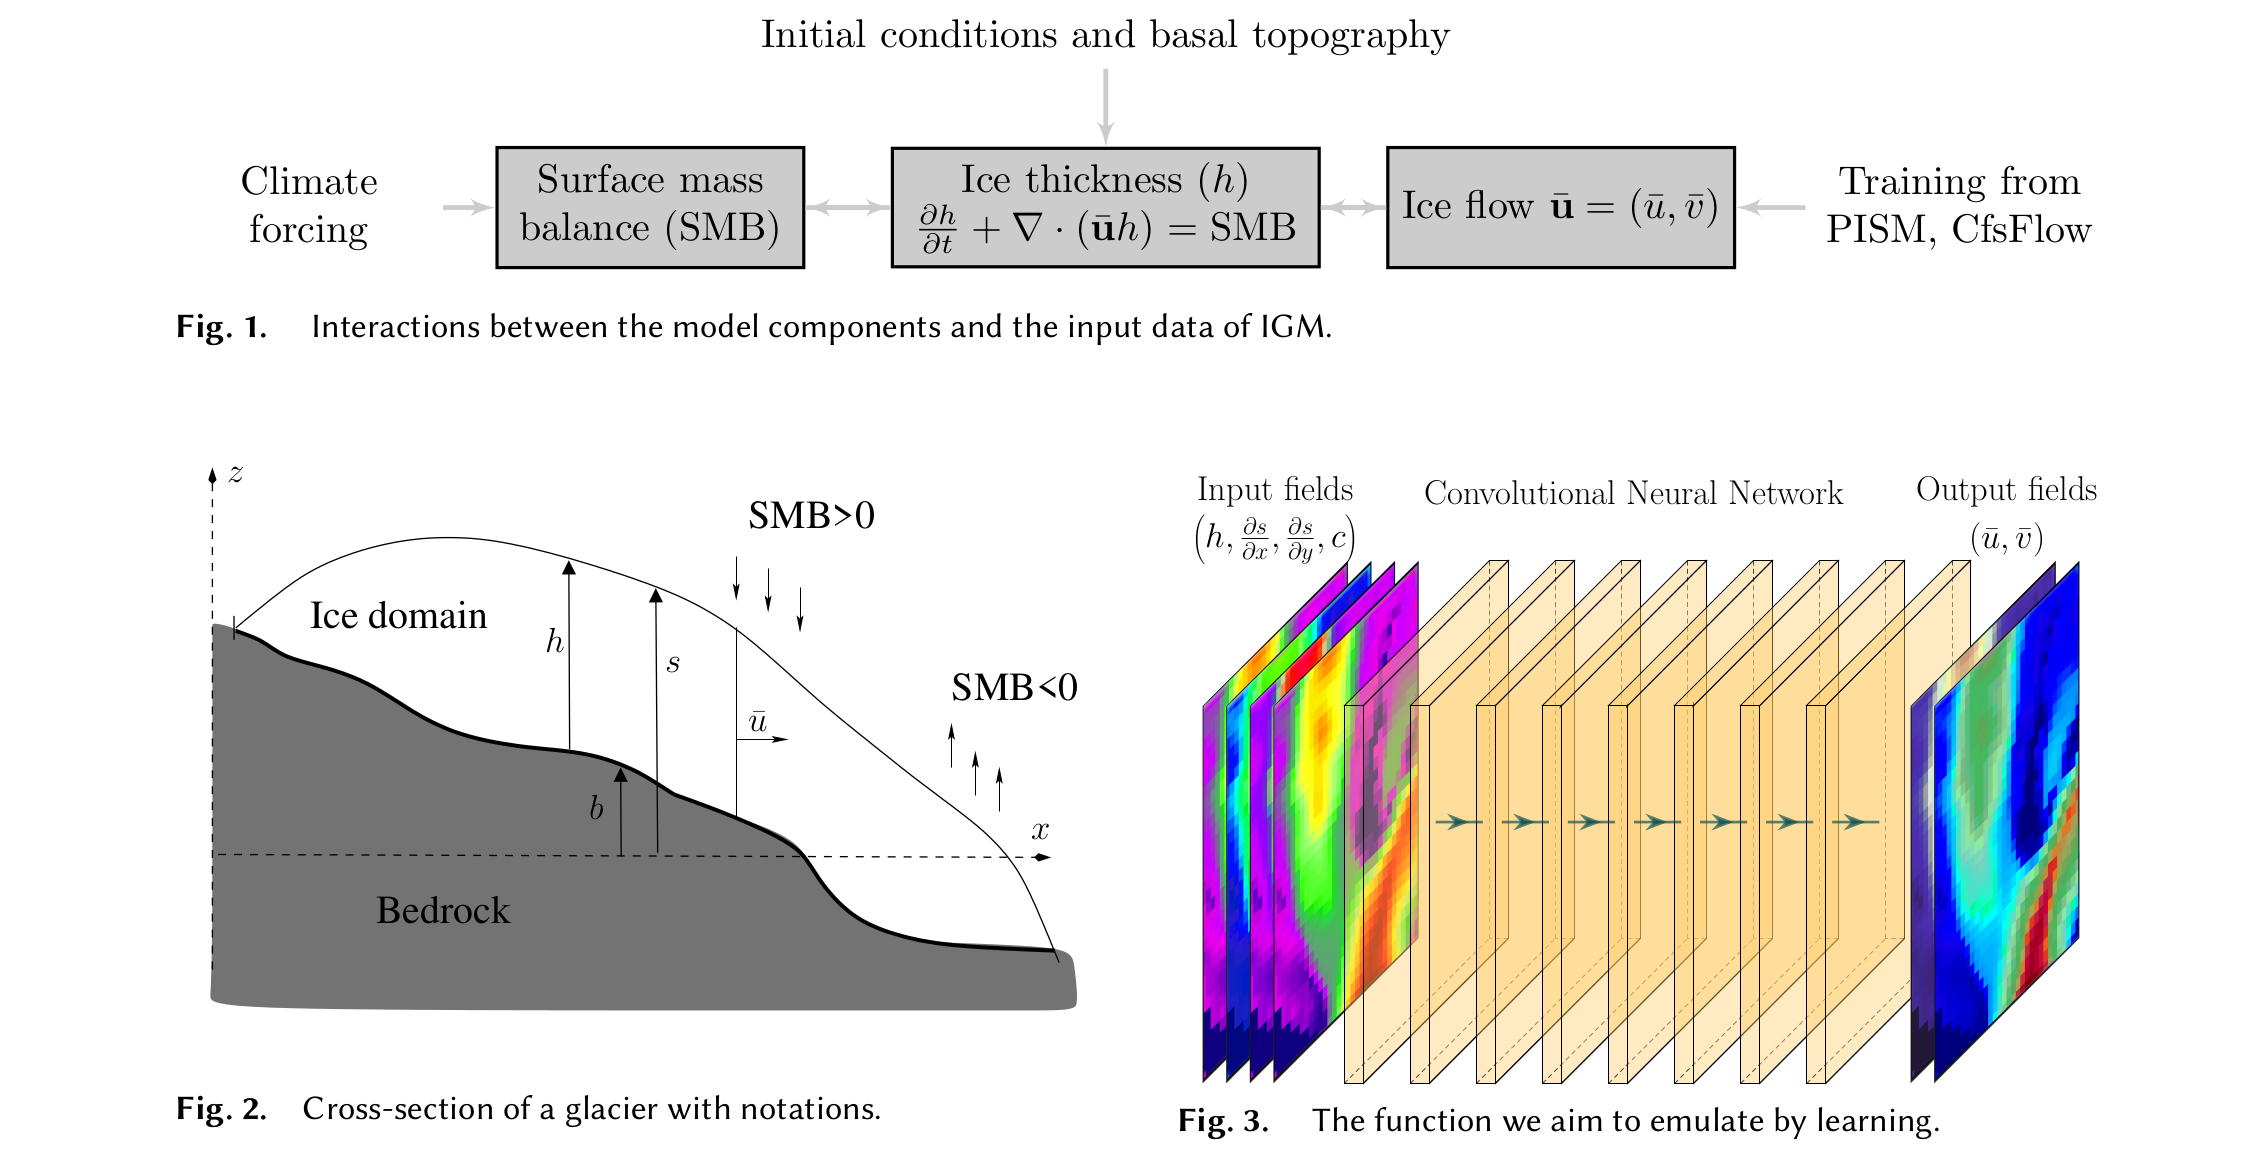Let us firt download the IGM code, ice flow emulator, and input data

 Step 1) download code, data and trained ice flow neural network

In [ ]:
# get the core source of igm (in igm.py)
!wget -nv -O igm.py https://raw.githubusercontent.com/jouvetg/igm/main/src/igm.py

# get input data
!wget -nv -O geology.nc https://raw.githubusercontent.com/jouvetg/igm/main/examples/aletsch-simple/geology.nc

# get the ice flow emulator
!apt install subversion
!svn export https://github.com/jouvetg/igm/trunk/model-lib/f15_cfsflow_GJ_22_a

Step 2) Vizualize the data


In [ ]:
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt

nc = Dataset('geology.nc', "r")
for var in nc.variables:
      print(var)
      vars()[var] = np.squeeze(nc.variables[var])
nc.close()

plt.imshow(usurf,origin='lower') ; plt.colorbar()

Step 4) define a mass balance parametrized by the ELA (Equilibrium Line Altitude)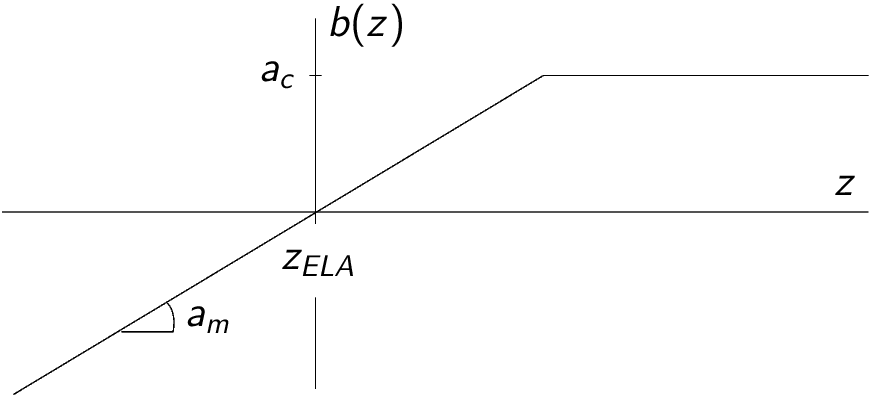

In [ ]:
import sys
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf 
sys.argv = ['']  # this is absolutly necessary in Jupyter notebook
from igm import Igm 
import math

class Igm(Igm):

    def update_smb_sinus(self):
        """
            mass balance 'sinus'
        """

        ela     = 2700 + 500*math.sin((self.t/50)*math.pi)
        gradabl = 0.009
        gradacc = 0.005
        maxacc  = 2.0

        smb = self.usurf - ela
        smb *= tf.where(tf.less(smb, 0), gradabl, gradacc)
        smb = tf.clip_by_value(smb, -100, maxacc)
        smb = tf.where(self.icemask>0.5, smb, -10 )

        self.smb.assign( smb )

glacier = Igm()

4) run IGM

In [ ]:
glacier.config.tstart                 = 0
glacier.config.tend                   = 800
glacier.config.tsave                  = 10
glacier.config.cfl                    = 0.3
glacier.config.init_slidingco         = 12
glacier.config.init_arrhenius         = 78
glacier.config.iceflow_model_lib_path = 'f15_cfsflow_GJ_22_a'
glacier.config.type_mass_balance      = 'sinus'

glacier.initialize() 
with tf.device(glacier.device_name):
    glacier.load_ncdf_data(glacier.config.geology_file)
    glacier.initialize_fields()               
    while glacier.t < glacier.config.tend:                       
        glacier.update_smb()
        glacier.update_iceflow()
        glacier.update_t_dt() 
        glacier.update_thk()       
        glacier.update_ncdf_ex()
        glacier.update_ncdf_ts()
        glacier.update_plot()
        glacier.print_info()
        
glacier.print_all_comp_info()   

# Vizualize
glacier.animate_result('ex.nc','thk',save=True)
glacier.animate_result('ex.nc','velsurf_mag',save=True)

5) Vizualize

In [ ]:
glacier.animate_result('ex.nc','thk',save=True)
glacier.animate_result('ex.nc','velsurf_mag',save=True)

Clean behind you

In [ ]:
# clean all
! rm -r f15_cfsflow_GJ_22_a f12_cfsflow_GJ_21_a  __pycache__  *.mp4
! rm *.nc  *.py *.dat *.txt igm-run-parameters.txt *.mp4 *.dat *.png